In [2]:
import pandas as pd
import numpy as np
from lexicon_lab_Bahareh import Similarity, Clusters

# Read the models and data
def read_model(file_path):
    with open(file_path, 'r') as file:
        model = {}
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            model[word] = coefs
    return model

word2vec = read_model("word2vec.txt")
speech2vec = read_model("speech2vec.txt")
data = pd.read_csv('data-cochlear.txt', sep='\t', names=['ID', 'Word'])

import os


data

,ID,Word
0,CAF-657,lizard
1,CAF-657,cat
2,CAF-657,hawk
3,CAF-657,dog
4,CAF-657,turtle
...,...,...
1302,SZA-781,puppy
1303,SZA-781,kitten
1304,SZA-781,goose
1305,SZA-781,duck


In [3]:
# Check if all vectors have 50 dimensions in word2vec
all_50_dim_w2v = all(len(v) == 50 for v in word2vec.values())
print("All vectors in word2vec have 50 dimensions:", all_50_dim_w2v)

# Check if all vectors have 50 dimensions in speech2vec
all_50_dim_s2v = all(len(v) == 50 for v in speech2vec.values())
print("All vectors in speech2vec have 50 dimensions:", all_50_dim_s2v)

# If there's an inconsistency, let's find out which words are causing the problem:
if not all_50_dim_w2v:
    for word, vec in word2vec.items():
        if len(vec) != 50:
            print(f"'{word}' in word2vec has {len(vec)} dimensions.")

if not all_50_dim_s2v:
    for word, vec in speech2vec.items():
        if len(vec) != 50:
            print(f"'{word}' in speech2vec has {len(vec)} dimensions.")

All vectors in word2vec have 50 dimensions: True
All vectors in speech2vec have 50 dimensions: True


In [4]:
def correct_file(filename):
    # Read the file content
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Filter out lines with incorrect dimensions
    corrected_lines = [line for line in lines if len(line.split()) == 51]

    # Write the corrected lines back to the file
    with open(filename, 'w') as f:
        f.writelines(corrected_lines)

    print(f"Corrected {filename}")

# Correct both files
correct_file('word2vec.txt')
correct_file('speech2vec.txt')


word2vec = read_model("word2vec.txt")
speech2vec = read_model("speech2vec.txt")

Corrected word2vec.txt
Corrected speech2vec.txt


In [5]:
from sklearn.metrics.pairwise import cosine_similarity


# Instantiate the similarity class
similarity = Similarity()

# Compute pairwise similarity using both models
pairwise_sim_word2vec = similarity.pairwise_similarity(data, word2vec, "word2vec")
pairwise_sim_speech2vec = similarity.pairwise_similarity(data, speech2vec, "speech2vec")





In [6]:
# Convert results to long format
def convert_to_long_format(df, model_name):
    long_format_data = []
    
    for _, row in df.iterrows():
        ID = row['ID']
        word = row['Word']
        similarities = row['Similarities']
        
        # The first similarity value (2) has already been included.
        # We'll now append the rest to the list
        for i, similarity_val in enumerate(similarities[1:]):  # Starting from 1 to skip the value 2
            long_format_data.append([ID, word, i+2, similarity_val, model_name])  # i+2 since we're excluding the first similarity value
            
    return pd.DataFrame(long_format_data, columns=['ID', 'Word', 'Word_Position', 'Similarity', 'Model'])

word2vec_long = convert_to_long_format(pairwise_sim_word2vec, 'word2vec')
speech2vec_long = convert_to_long_format(pairwise_sim_speech2vec, 'speech2vec')

# Combine both long format dataframes
combined_results = pd.concat([word2vec_long, speech2vec_long], ignore_index=True)

# Save to desired format
if not os.path.exists('results'):
    os.makedirs('results')

combined_results.to_csv('results/pairwise_similarity_results.csv', index=False)

In [7]:
import os
import pandas as pd
from itertools import combinations
from lexicon_lab_Bahareh import Similarity

# Assuming read_model function is defined here or imported
from gensim.models import KeyedVectors


# Instantiate Similarity class
similarity_obj = Similarity()

# Compute the cosine similarity for every unique word pair in your dataset

all_unique_words = data['Word'].unique()
word_pairs = combinations(all_unique_words, 2)

results = []

for word1, word2 in word_pairs:
    similarity_value_word2vec = similarity_obj.cosine_similarity_func(word1, word2, word2vec)
    similarity_value_speech2vec = similarity_obj.cosine_similarity_func(word1, word2, speech2vec)
    
    results.append([word1, word2, similarity_value_word2vec, 'word2vec'])
    results.append([word1, word2, similarity_value_speech2vec, 'speech2vec'])

# Convert results to DataFrame
df_results = pd.DataFrame(results, columns=["Word1", "Word2", "Similarity", "Model"])

# Create 'results' directory if not exists
if not os.path.exists('results'):
    os.makedirs('results')

# Save to a csv file
df_results.to_csv('results/cosine_similarity_results.csv', index=False)



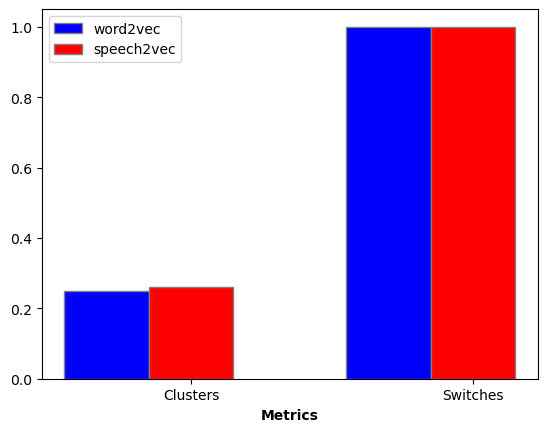

In [8]:

# Instantiate the Clusters class
clusters_obj = Clusters()

# Compute clusters
clusters_obj.compute_clusters(data, word2vec, speech2vec)


clusters_obj.visualize_clusters()

